# Machine Learning Nanodegree
## Capstone Project: Electric Vehicle Detection 

### Setup

In [1]:
# Import libraries necessary for this project
import numpy as np
import pandas as pd
from IPython.display import display 

# Pretty display for notebooks
%matplotlib inline

### Data Exploration

In [2]:
ev_train = pd.read_csv('EV_train.csv')
ev_train.head()

,House ID,Interval_1,Interval_2,Interval_3,Interval_4,Interval_5,Interval_6,Interval_7,Interval_8,Interval_9,...,Interval_2871,Interval_2872,Interval_2873,Interval_2874,Interval_2875,Interval_2876,Interval_2877,Interval_2878,Interval_2879,Interval_2880
0,11655099,0.950,0.826,0.361,0.238,0.342,0.233000,0.351000,0.194000,0.292000,...,0.664,0.783,0.601,0.639,0.417,0.439,0.226,0.190,0.710,0.728
1,11633257,0.353,0.327,0.358,0.292,0.285,0.304000,0.361000,0.342000,0.355000,...,0.536,0.558,0.622,0.634,0.513,0.421,0.273,0.296,0.291,0.289
2,11651552,0.150,0.181,0.150,0.150,0.131,0.125000,0.088000,0.106000,0.094000,...,2.125,0.881,0.481,1.194,0.138,0.119,0.038,0.088,0.056,0.113
3,11636092,2.088,2.075,2.121,2.098,2.046,2.081000,1.847000,0.420000,0.399000,...,0.620,0.487,0.563,0.419,0.379,0.359,0.347,0.325,0.330,0.340
4,11647239,1.416,1.250,1.270,1.258,1.239,1.753105,4.609256,4.619256,4.075151,...,1.596,1.667,1.569,1.664,1.580,1.635,1.568,1.565,1.575,1.571


In [3]:
ev_train_labels = pd.read_csv('EV_train_labels.csv')
ev_train_labels.head()

,House ID,Interval_1,Interval_2,Interval_3,Interval_4,Interval_5,Interval_6,Interval_7,Interval_8,Interval_9,...,Interval_2871,Interval_2872,Interval_2873,Interval_2874,Interval_2875,Interval_2876,Interval_2877,Interval_2878,Interval_2879,Interval_2880
0,11655099,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,11633257,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,11651552,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,11636092,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,11647239,0,0,0,0,0,1,1,1,1,...,0,0,0,0,0,0,0,0,0,0


In [4]:
ev_prevalence = ev_train_labels.iloc[:,1:len(ev_train_labels.columns)].sum(axis=1)

In [5]:
sum(ev_prevalence > 0)

485

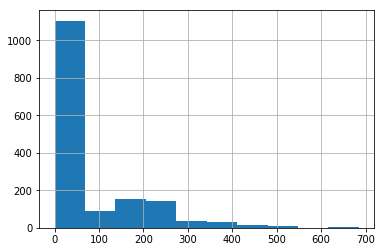

In [6]:
ev_prevalence.hist()

In [7]:
ev_train.shape

(1590, 2881)

In [8]:
485/1590

0.3050314465408805

In [9]:
ev_train_labels.shape

(1590, 2881)

In [10]:
ev_train.iloc[:6,1:49].sum(axis=1)

0    26.647000
1    27.632000
2    36.282000
3    67.616000
4    72.476768
5    39.322000
dtype: float64

In [11]:
900/30

30.0

In [12]:
ev_prevalence.head()

0      0
1      0
2      0
3      0
4    117
dtype: int64

In [22]:
np.mean(ev_prevalence[ev_prevalence > 0]/2880)

0.076539232531500578